# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
pip install xgboost

     |████████████████████████████████| 166.7 MB 33 kB/s /s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=ac2de051946dc2abcc477a71e04c60381186a43307583c1738eafda36ab83f0e
  Stored in directory: /home/ec2-user/.cache/pip/wheels/22/cf/f4/600b7619db8e0ce75023fc14145fc432a54522b7b7b4778ecf
Successfully built bayesian-optimization
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install lightgbm

     |████████████████████████████████| 2.0 MB 27.8 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scikit-optimize==0.8.1

     |████████████████████████████████| 101 kB 14.9 MB/s ta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-learn==0.23.2

     |████████████████████████████████| 6.8 MB 22.9 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).




In [6]:
# import libraries here; add more as necessary

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

from sklearn.impute import SimpleImputer

from utils import  *
# import skopt
# from skopt import BayesSearchCV
# class BayesSearchCV(BayesSearchCV):
#     def _run_search(self, x): raise BaseException('Use newer skopt')

%matplotlib inline
plt.style.use('fivethirtyeight')

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).


In [7]:
# load in the data
azdias = pd.read_csv('../../data/azdias.csv',sep=';')
customers = pd.read_csv('../../data/customers.csv',sep=';')
attributes = pd.read_excel('../../data/attributes.xlsx' , engine='openpyxl', skiprows = 1)

#drop 3 of the customer columns which are missing in the global population dataset
customers_clean = customers.drop(['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'], axis = 1, inplace = True)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
#size of the datasets
print('azdias dimensions: ' + str(azdias.shape))
print('customers dimensions: ' + str(customers.shape))

azdias dimensions: (891221, 366)
customers dimensions: (191652, 366)


In [9]:
#azdias first 5 rows
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [10]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3


In [11]:
#desription of the azdias frame (Unnamed: 0 looks like repeats the index and LNR is the ID of each person)
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [12]:
#check for object values within the dataset
print(cat_check(azdias))

CAMEO_DEU_2015                45
CAMEO_DEUG_2015               19
CAMEO_INTL_2015               43
D19_LETZTER_KAUF_BRANCHE      35
EINGEFUEGT_AM               5162
OST_WEST_KZ                    2
dtype: int64


In [13]:
# as we can see the there are some X and XX values that should be corrected in the following columns
print(azdias['CAMEO_DEU_2015'].unique())
print(azdias['CAMEO_DEUG_2015'].unique())
print(azdias['CAMEO_INTL_2015'].unique())

[nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C' 'XX']
[nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
[nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX']


EINGEFUEGT_AM is a datetime column and OST_WEST_KZ should be mapped to binary values
all transpormations are done in feature_transform() in file utils.py

In [14]:
attributes.drop(['Unnamed: 0'], axis = 1, inplace = True)

### Missing values

In [15]:
#use the attributes xls file to map the 0,-1,9 values to -1
azdias = unknown_unify(azdias, attributes)
customers = unknown_unify(customers, attributes)

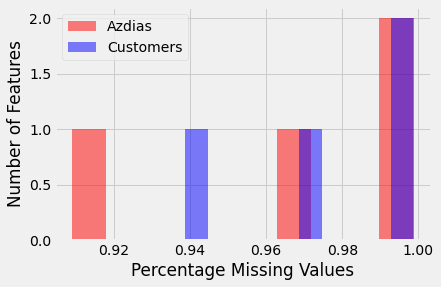

In [16]:
#missing vaues per feature histogram
col_azdiaz = azdias.isnull().sum()/len(azdias)
col_customers = customers.isnull().sum()/len(customers)
plt.hist(col_azdiaz[col_azdiaz > 0.8], fc=(1, 0, 0, 0.5), label='Azdias')
plt.hist(col_customers[col_customers > 0.8], fc=(0, 0, 1, 0.5), label='Customers')
plt.xlabel('Percentage Missing Values')
plt.ylabel('Number of Features')
plt.legend()

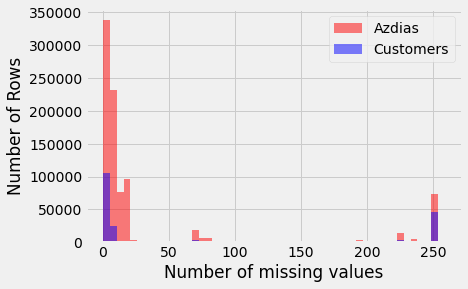

In [17]:
#plot histogram missing values per row
bins = 50
plt.hist(azdias.isnull().sum(axis=1), bins, fc=(1, 0, 0, 0.5), label='Azdias')
plt.hist(customers.isnull().sum(axis=1), bins, fc=(0, 0, 1, 0.5), label='Customers')
plt.xlabel('Number of missing values')
plt.ylabel('Number of Rows')
plt.legend()

In [18]:
#display features with more than 30% missing values
missing_values = azdias.isnull().sum()/len(azdias)
azdias[missing_values[missing_values > 0.80].index].head()

,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


####      ALTER_KIND features mark the age of children. Having a lot of NaN values is normal and dropping the features may result in loosing information.

In [19]:
#transforming some of the features and removing incorrect values
azdias = feature_transform(azdias)
customers = feature_transform(customers)

Creating PRAEGENDE_JUGENDJAHRE_DECADE feature
Creating PRAEGENDE_JUGENDJAHRE_MOVEMENT feature
Creating PRAEGENDE_JUGENDJAHRE_DECADE feature
Creating PRAEGENDE_JUGENDJAHRE_MOVEMENT feature


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


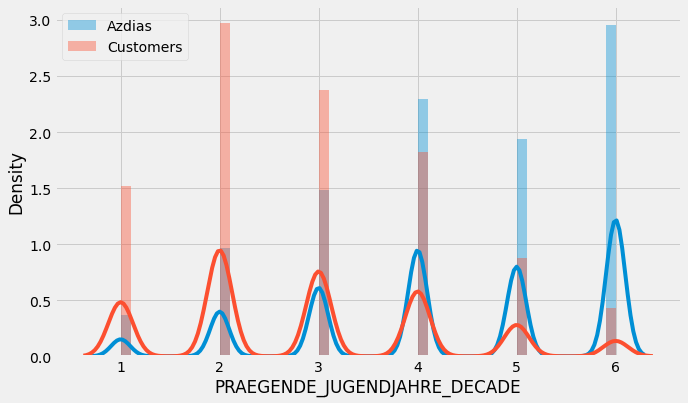

In [20]:
#Distribution of DECADE feature
fig = plt.figure(figsize = (10,6))
sns.distplot(azdias['PRAEGENDE_JUGENDJAHRE_DECADE'], norm_hist = True, label='Azdias')
sns.distplot(customers['PRAEGENDE_JUGENDJAHRE_DECADE'], norm_hist = True, label='Customers')
plt.legend()

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


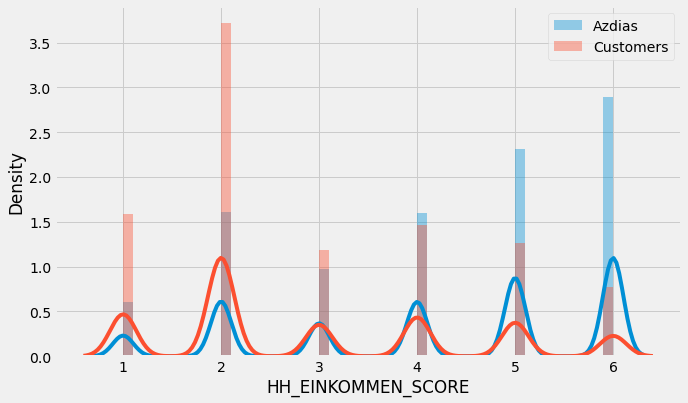

In [21]:
#Distribution of INCOME feature
fig = plt.figure(figsize = (10,6))
sns.distplot(azdias['HH_EINKOMMEN_SCORE'], norm_hist = True, label='Azdias')
sns.distplot(customers['HH_EINKOMMEN_SCORE'], norm_hist = True, label='Customers')
plt.legend()

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


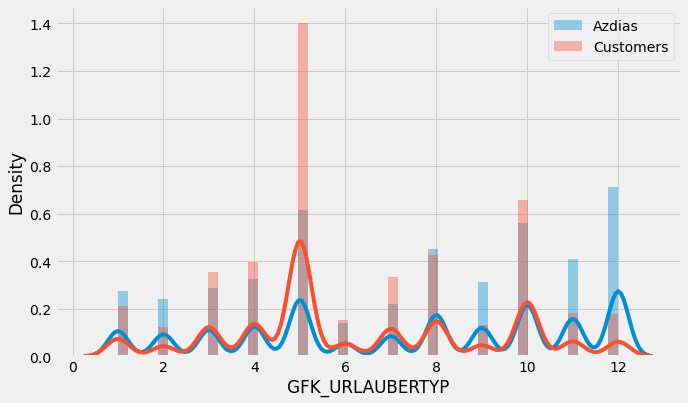

In [22]:
#Distribution of VACATION HABITS feature
fig = plt.figure(figsize = (10,6))
sns.distplot(azdias['GFK_URLAUBERTYP'], norm_hist = True, label='Azdias')
sns.distplot(customers['GFK_URLAUBERTYP'], norm_hist = True, label='Customers')
plt.legend()

## Part 1: Unsupervised model:

In [23]:
#unsupervised data preprocessing
pipeline_unsup = Pipeline([  ('impute', SimpleImputer(strategy= 'constant', fill_value = -1)),
                             ('scale', StandardScaler()),
                             ('pca' , PCA()),
                        ])

#fit and transform the sets
azdias_pca = pipeline_unsup.fit_transform(azdias)
customers_pca =  pipeline_unsup.transform(customers)

In [24]:
pipeline_unsup

Pipeline(steps=[('impute', SimpleImputer(fill_value=-1, strategy='constant')),
                ('scale', StandardScaler()), ('pca', PCA())])

In [25]:
type(pipeline_unsup)

sklearn.pipeline.Pipeline

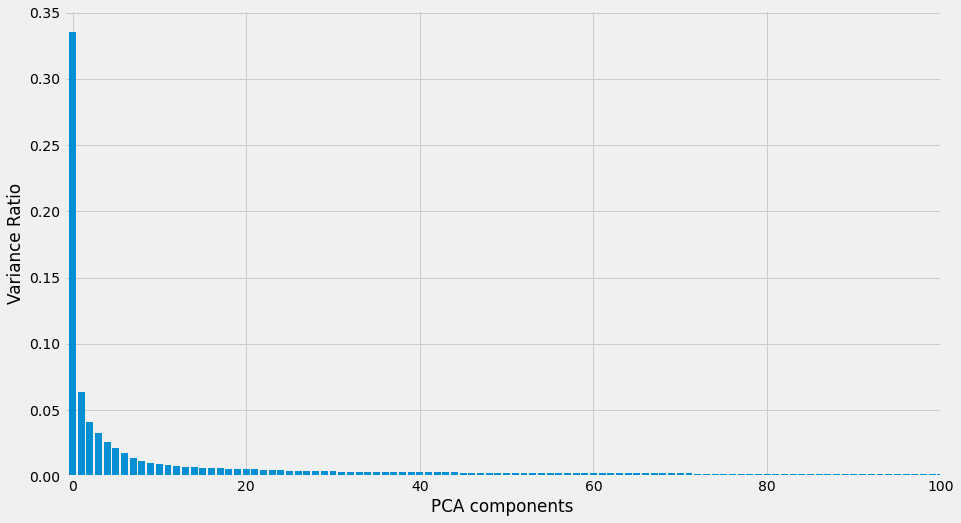

0.8999071544374209

In [26]:
#calculate PCA features to use in the clustering model
fig = plt.figure(figsize = (14,8))
plt.bar(list(range(0, len(pipeline_unsup[2].explained_variance_ratio_))), pipeline_unsup[2].explained_variance_ratio_)
plt.xlabel('PCA components')
plt.ylabel('Variance Ratio')
plt.xlim(-1, 100)
plt.show()

pipeline_unsup[2].explained_variance_ratio_[:130].sum()

In [27]:
len(pipeline_unsup[2].explained_variance_ratio_)

364

In [33]:
#calculate number of clusters for the KMeans++ model:
score = []

for i in range(2,15):
    clt = KMeans(n_clusters = i)
    global_cluster = clt.fit(azdias_pca[:, :130])
    score.append(global_cluster.inertia_)
    print(score[i-2])



188191341.2686641
173872621.73497579
162819559.36767477
156367018.1789475
151753958.26079398
148195501.2181709
145546430.8019744
143484554.1449105
141811301.3827675
140551889.57581416
138957163.07629836
137531269.92168036
137423189.17870772


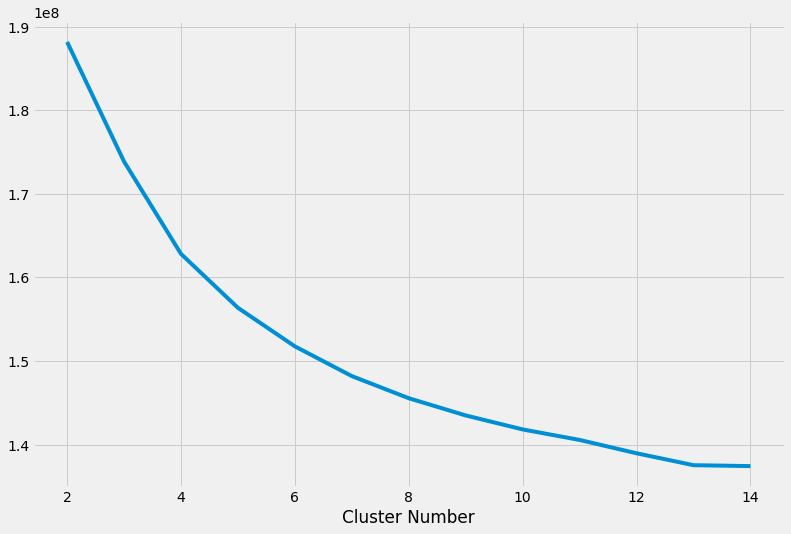

In [34]:
#plow elbow curve
fig = plt.figure(figsize = (12,8))
sns.lineplot(x = list(range(2,15)), y = score)
plt.xlabel('Cluster Number')
plt.show()

In [35]:
#init and fit the Kmeans++ with the desirable number of clusters (10)
clt = KMeans(n_clusters = 8)

azdiaz_cluster = clt.fit(azdias_pca[:, :130])

In [36]:
#predict cluster labels for arvato customerz
customers_cluster = clt.predict(customers_pca[:, :130])

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


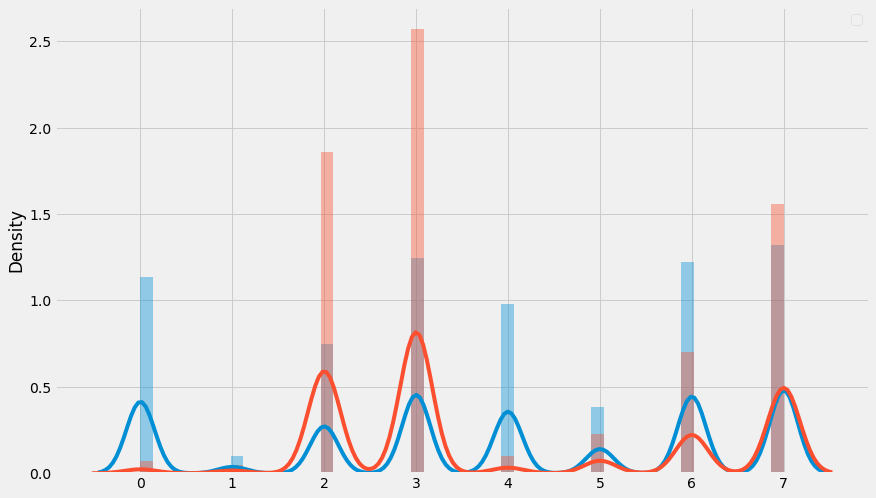

In [37]:
#plot the distribution between azdias and customers data inside the clusters
fig = plt.figure(figsize = (13,8))
sns.distplot(azdiaz_cluster.labels_)
sns.distplot(customers_cluster)
plt.legend()
plt.show()

#### Let's take a look at the features between the two most different clusters

### Identify important feature differences between the clusters

In [38]:
azdias_clst = azdias
azdias_clst['Cluster'] = azdiaz_cluster.labels_

customers_clst = customers
customers_clst['Cluster'] = customers_cluster

azdias_clst = azdias_clst[azdias_clst['Cluster'] == 4]
customers_clst = customers_clst[customers_clst['Cluster'] == 0]

#get mean difference between features
diff = pd.DataFrame({'Cluster_4': azdias_clst.mean(), 'Cluster_0': customers_clst.mean()})
diff['delta'] = abs(diff['Cluster_4'] - diff['Cluster_0'])
diff.head(20).sort_values(['delta'], ascending = False)

,Cluster_4,Cluster_0,delta
CAMEO_INTL_2015,46.901826,29.923393,16.978432
ANZ_HAUSHALTE_AKTIV,16.533696,4.371986,12.161710
ANZ_STATISTISCHE_HAUSHALTE,14.657256,3.993330,10.663926
ALTERSKATEGORIE_FEIN,17.332371,13.280834,4.051537
CAMEO_DEUG_2015,7.741682,4.541388,3.200294
AKT_DAT_KL,5.585192,3.393535,2.191657
ALTER_KIND3,14.640662,12.769231,1.871431
BALLRAUM,3.019517,4.779261,1.759744
ARBEIT,3.732536,2.629917,1.102618
ALTER_HH,12.350251,11.322217,1.028034


##### CAMEO_DEUG_2015: Customers are more likely to be 'established middle class' against Cluster 3 values : low-consumption middleclass.

##### CAMEO_INTL_2015: Prosperous households are more likely to be customers.

##### ANZ_PERSONEN: Households with more adult people use the company's products.

##### ALTER_HH: The main age within the households of customers is lower than the underrepresented cluster.

